# Data Ingestion, Preprocessing and Labelling

In [1]:
import json

In [2]:
# File path for the review dataset
review_path = "yelp_academic_dataset_review.json"

In [10]:
# Function to load the review dataset without excessive logs
def load_review_dataset(file_path, chunk_size=10000):
    print(f"Loading {file_path}...")
    data = []
    
    # Read the JSON file line by line
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            data.append(json.loads(line))
    
    print(f"Completed loading {file_path}. Total lines: {len(data)}")
    return data  # Return the dataset as a list of dictionaries

In [11]:
# Load the review dataset
review_data = load_review_dataset(review_path)

# Display the first record to verify
print("First record in the review dataset:")
print(review_data[0])

Loading yelp_academic_dataset_review.json...
Completed loading yelp_academic_dataset_review.json. Total lines: 6990280
First record in the review dataset:
{'review_id': 'KU_O5udG6zpxOg-VcAEodg', 'user_id': 'mh_-eMZ6K5RLWhZyISBhwA', 'business_id': 'XQfwVwDr-v0ZS3_CbbE5Xw', 'stars': 3.0, 'useful': 0, 'funny': 0, 'cool': 0, 'text': "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.", 'date': '2018-07-07 22:09:11'}


In [16]:
# Filter out relevant columns: text, stars, cool, funny, useful
filtered_reviews = [
    {
        "text": record["text"],
        "stars": record["stars"],
        "cool": record["cool"],
        "funny": record["funny"],
        "useful": record["useful"]
    }
    for record in review_data
]

# Display the first filtered record
print(f"Filtered reviews: {len(filtered_reviews)} records")
print("First filtered record:")
print(filtered_reviews[0])

Filtered reviews: 6990280 records
First filtered record:
{'text': "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.", 'stars': 3.0, 'cool': 0, 'funny': 0, 'useful': 0}


In [17]:
# Function to label sentiments
def label_sentiment(stars):
    if stars >= 4:
        return "Positive"
    elif stars == 3:
        return "Neutral"
    else:
        return "Negative"

# Add sentiment labels
for review in filtered_reviews:
    review["sentiment"] = label_sentiment(review["stars"])

# Display the first record with sentiment
print("First record with sentiment:")
print(filtered_reviews[0])

First record with sentiment:
{'text': "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.", 'stars': 3.0, 'cool': 0, 'funny': 0, 'useful': 0, 'sentiment': 'Neutral'}


## Data Preprocessing

In [28]:
from transformers import AutoTokenizer
import torch

# Load a pre-trained tokenizer (BERT tokenizer)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
print("Tokenizer loaded successfully!")

Tokenizer loaded successfully!


In [20]:
def preprocess_text_with_tokenizer(batch):
    # Tokenize the batch of text on the GPU
    tokenized = tokenizer(
        batch,
        padding=True,          # Pad sentences to the same length
        truncation=True,       # Truncate long sentences
        max_length=128,        # Limit sequence length to 128 tokens
        return_tensors="pt"    # Return PyTorch tensors
    ).to("cuda")              # Move the result to the GPU
    return tokenized

In [21]:
import random

# Define subset size
subset_size = 1000000

# Randomly sample a subset of the data
subset_reviews = random.sample(filtered_reviews, subset_size)

# Display the size of the subset
print(f"Subset size: {len(subset_reviews)} reviews")
print("First review in the subset:")
print(subset_reviews[0])

Subset size: 1000000 reviews
First review in the subset:
{'text': 'Hibachi Station was delicious and hot and fresh clean restaurant.. stacked bar... Clean restroom', 'stars': 3.0, 'cool': 0, 'funny': 0, 'useful': 0, 'sentiment': 'Neutral'}


In [30]:
# Define batch size
batch_size = 100000

# Extract text data from the subset
texts = [review["text"] for review in subset_reviews]

# Process the text in batches
processed_batches = []
for i in range(0, len(texts), batch_size):
    print(f"Processing batch {i // batch_size + 1} out of {len(texts) // batch_size + 1}...")
    batch = texts[i:i + batch_size]
    tokenized_batch = preprocess_text_with_tokenizer(batch)  # Tokenize with GPU acceleration
    processed_batches.append(tokenized_batch["input_ids"])  # Only store input IDs

# Flatten the processed batches into a single tensor
processed_tensors = torch.cat(processed_batches, dim=0)

# Store processed tensors back into the subset_reviews dataset
for i, review in enumerate(subset_reviews):
    review["processed_text"] = processed_tensors[i].tolist()  # Convert tensors to lists for storage
    
# Display the first record with processed text
print("First record after GPU-accelerated tokenization:")
print(subset_reviews[0])

Processing batch 1 out of 11...
Processing batch 2 out of 11...
Processing batch 3 out of 11...
Processing batch 4 out of 11...
Processing batch 5 out of 11...
Processing batch 6 out of 11...
Processing batch 7 out of 11...
Processing batch 8 out of 11...
Processing batch 9 out of 11...
Processing batch 10 out of 11...
First record after GPU-accelerated tokenization:
{'text': 'Hibachi Station was delicious and hot and fresh clean restaurant.. stacked bar... Clean restroom', 'stars': 3.0, 'cool': 0, 'funny': 0, 'useful': 0, 'sentiment': 'Neutral', 'processed_text': [101, 7632, 7693, 2072, 2276, 2001, 12090, 1998, 2980, 1998, 4840, 4550, 4825, 1012, 1012, 16934, 3347, 1012, 1012, 1012, 4550, 28249, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### Stopword Removal

In [41]:
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download("stopwords")

# Load English stopwords
stop_words = set(stopwords.words("english"))

# Convert stopwords to token IDs
stopword_ids = tokenizer.convert_tokens_to_ids(list(stop_words))

# Remove `None` values for words not in the tokenizer's vocabulary
stopword_ids = [token_id for token_id in stopword_ids if token_id is not None]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chetn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
from torch.nn.utils.rnn import pad_sequence

# Function to remove stopwords and pad sequences
def remove_stopwords_and_pad(tokenized_batch, max_length=128):
    token_ids = tokenized_batch["input_ids"]
    
    # Remove stopwords from each sequence
    filtered_tokens = [
        [token for token in seq if token not in stopword_ids] for seq in token_ids
    ]
    
    # Convert to PyTorch tensors
    filtered_tensors = [torch.tensor(seq) for seq in filtered_tokens]
    
    # Pad sequences to max_length
    padded_tensors = pad_sequence(filtered_tensors, batch_first=True, padding_value=tokenizer.pad_token_id)
    
    # Truncate sequences to the max_length
    return padded_tensors[:, :max_length]

In [49]:
# Apply stopword removal and padding to all batches
processed_batches_no_stopwords = [
    remove_stopwords_and_pad({"input_ids": batch.tolist()}, max_length=128).to("cuda")
    for batch in processed_batches
]

# Flatten the processed batches without stopwords into a single tensor
processed_tensors_no_stopwords = torch.cat(processed_batches_no_stopwords, dim=0)

# Update the subset_reviews dataset with stopword-removed tokens
for i, review in enumerate(subset_reviews):
    review["processed_text_no_stopwords"] = processed_tensors_no_stopwords[i].tolist()

# Display the first record with stopwords removed
print("First record after stopword removal and padding:")
print(subset_reviews[0])

First record after stopword removal and padding:
{'text': 'Hibachi Station was delicious and hot and fresh clean restaurant.. stacked bar... Clean restroom', 'stars': 3.0, 'cool': 0, 'funny': 0, 'useful': 0, 'sentiment': 'Neutral', 'processed_text': [101, 7632, 7693, 2072, 2276, 2001, 12090, 1998, 2980, 1998, 4840, 4550, 4825, 1012, 1012, 16934, 3347, 1012, 1012, 1012, 4550, 28249, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'processed_text_no_stopwords': [101, 7632, 7693, 2072, 2276, 12090, 2980, 4840, 4550, 4825, 1012, 1012, 16934, 3347, 1012, 1012, 1012, 4550, 28249, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Labelling and Storing Data

In [51]:
# Define sentiment mapping
sentiment_mapping = {"Positive": 2, "Neutral": 1, "Negative": 0}

# Convert labels
for review in subset_reviews:
    review["label"] = sentiment_mapping[review["sentiment"]]

In [55]:
# Save the labeled dataset as JSON
with open("labeled_reviews.json", "w", encoding="utf-8") as f:
    json.dump(subset_reviews, f, ensure_ascii=False, indent=4)

print("Dataset saved as labeled_reviews.json")

Dataset saved as labeled_reviews.json


# Feature Extraction

In [69]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Count Vectors for Unigram

In [77]:
# Extract the processed text
texts = [review["processed_text_no_stopwords"] for review in subset_reviews]
texts = [" ".join(map(str, text)) for text in texts]  # Convert tokenized sequences to space-separated strings

# Initialize CountVectorizer for unigram
count_vectorizer_unigram = CountVectorizer(ngram_range=(1, 1), max_features=20000)  # Unigram only

# Fit and transform the texts
X_count_unigram = count_vectorizer_unigram.fit_transform(texts)

print("Count Vectors for Unigram created!")
print(f"Feature matrix shape: {X_count_unigram.shape}")

Count Vectors for Unigram created!
Feature matrix shape: (1000000, 20000)


### Count Vectors for Unigram + Bigram

In [94]:
# Extract the processed text
texts = [review["processed_text_no_stopwords"] for review in subset_reviews]
texts = [" ".join(map(str, text)) for text in texts]  # Convert tokenized sequences to space-separated strings

# Initialize CountVectorizer for unigram
count_vectorizer_unigram = CountVectorizer(ngram_range=(1, 2), max_features=20000)  # Unigram only

# Fit and transform the texts
X_count_unigram_bigram = count_vectorizer_unigram.fit_transform(texts)

print("Count Vectors for Unigram+Bigram created!")
print(f"Feature matrix shape: {X_count_unigram.shape}")

Count Vectors for Unigram+Bigram created!
Feature matrix shape: (1000000, 20000)


### TF-IDF Vectors for Unigram+Bigram

In [73]:
# Initialize TfidfVectorizer for unigram+bigram
tfidf_vectorizer_unigram_bigram = TfidfVectorizer(ngram_range=(1, 2), max_features=40000)  # Unigram and bigram

# Fit and transform the texts
X_tfidf_unigram_bigram = tfidf_vectorizer_unigram_bigram.fit_transform(texts)

print("TF-IDF Vectors for Unigram+Bigram created!")
print(f"Feature matrix shape: {X_tfidf_unigram_bigram.shape}")

TF-IDF Vectors for Unigram+Bigram created!
Feature matrix shape: (1000000, 40000)


### One-Hot Vectors for Unigram+Bigram

In [81]:
# Initialize CountVectorizer for one-hot encoding (binary counts)
one_hot_vectorizer = CountVectorizer(ngram_range=(1, 2), binary=True, max_features=40000)  # Unigram and bigram

# Fit and transform the texts
X_one_hot_unigram_bigram = one_hot_vectorizer.fit_transform(texts)

print("One-Hot Vectors for Unigram+Bigram created!")
print(f"Feature matrix shape: {X_one_hot_unigram_bigram.shape}")

One-Hot Vectors for Unigram+Bigram created!
Feature matrix shape: (1000000, 40000)


### Class Distribution

In [99]:
# Extract labels from the 'label' field
y = [review["label"] for review in subset_reviews]

# Check the distribution of labels
from collections import Counter
print(f"Label distribution: {Counter(y)}")

Label distribution: Counter({2: 670327, 0: 230374, 1: 99299})


# Models - Naive Bayes

In [513]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import pandas as pd
import time
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns

### Data Split

In [516]:
# Split each feature set and the labels into training and testing sets
X_train_count_unigram, X_test_count_unigram, y_train_a, y_test_a = train_test_split(X_count_unigram, y, test_size=0.2, random_state=42, stratify=y)

X_train_count_unigram_bigram, X_test_count_unigram_bigram, y_train_b, y_test_b = train_test_split(X_count_unigram_bigram, y, test_size=0.2, random_state=42, stratify=y)

X_train_tfidf_unigram_bigram, X_test_tfidf_unigram_bigram, y_train_c, y_test_c = train_test_split(X_tfidf_unigram_bigram, y, test_size=0.2, random_state=42, stratify=y)

X_train_one_hot_unigram_bigram, X_test_one_hot_unigram_bigram,y_train_d, y_test_d = train_test_split(X_one_hot_unigram_bigram, y, test_size=0.2, random_state=42, stratify=y)

print("Train-test split completed!")

Train-test split completed!


### Store Results

In [518]:
def store_results(model_name, feature_extraction, dataset_type, accuracy, f1_scores, auc, train_time="N/A"):
    global results_df

    # Prepare the result dictionary
    result = {
        "Model": model_name,
        "Feature Extraction": feature_extraction,
        "Dataset": dataset_type,
        "Accuracy": accuracy,
        "F1 Score (Positive)": f1_scores.get("Positive", None),
        "F1 Score (Neutral)": f1_scores.get("Neutral", None),
        "F1 Score (Negative)": f1_scores.get("Negative", None),
        "AUC": auc if auc else None,
        "Train Time (s)": train_time if dataset_type == "Training" else None
    }

    # Remove None values from the dictionary
    result = {key: value for key, value in result.items() if value is not None}

    # Create results_df if it doesn't exist
    if "results_df" not in globals():
        results_df = pd.DataFrame(columns=result.keys())

    # Append the new row to the DataFrame
    new_row = pd.DataFrame([result])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    print(f"Results stored for {model_name} ({dataset_type})!")

### Count Vectors Unigram

In [520]:
# Train and evaluate Naive Bayes with Count Vectors (Unigram)
nb_model_count_unigram = MultinomialNB()

# Train the model
start_time = time.time()
nb_model_count_unigram.fit(X_train_count_unigram, y_train_a)
train_time = time.time() - start_time

# Predict probabilities and classes
y_train_prob_count_unigram = nb_model_count_unigram.predict_proba(X_train_count_unigram)
y_test_prob_count_unigram = nb_model_count_unigram.predict_proba(X_test_count_unigram)
y_pred_train_count_unigram = nb_model_count_unigram.predict(X_train_count_unigram)
y_pred_test_count_unigram = nb_model_count_unigram.predict(X_test_count_unigram)

# Evaluate on training data
train_conf_matrix_count_unigram = confusion_matrix(y_train_a, y_pred_train_count_unigram)
train_accuracy_count_unigram = accuracy_score(y_train_a, y_pred_train_count_unigram)
train_class_report_count_unigram = classification_report(
    y_train_a, y_pred_train_count_unigram, target_names=["Negative", "Neutral", "Positive"], output_dict=True
)

# Evaluate on testing data
test_conf_matrix_count_unigram = confusion_matrix(y_test_a, y_pred_test_count_unigram)
test_accuracy_count_unigram = accuracy_score(y_test_a, y_pred_test_count_unigram)
test_class_report_count_unigram = classification_report(
    y_test_a, y_pred_test_count_unigram, target_names=["Negative", "Neutral", "Positive"], output_dict=True
)

# Compute AUC
auc_count_unigram = roc_auc_score(y_test_a, y_test_prob_count_unigram, multi_class="ovr")

In [521]:
# Store training metrics
store_results(
    model_name="Naive Bayes",
    feature_extraction="Count Vectors (Unigram)",
    dataset_type="Training",
    accuracy=train_accuracy_count_unigram,
    f1_scores={
        "Positive": train_class_report_count_unigram["Positive"]["f1-score"],
        "Neutral": train_class_report_count_unigram["Neutral"]["f1-score"],
        "Negative": train_class_report_count_unigram["Negative"]["f1-score"]
    },
    auc="N/A",
    train_time=train_time
)

# Store testing metrics
store_results(
    model_name="Naive Bayes",
    feature_extraction="Count Vectors (Unigram)",
    dataset_type="Testing",
    accuracy=test_accuracy_count_unigram,
    f1_scores={
        "Positive": test_class_report_count_unigram["Positive"]["f1-score"],
        "Neutral": test_class_report_count_unigram["Neutral"]["f1-score"],
        "Negative": test_class_report_count_unigram["Negative"]["f1-score"]
    },
    auc=auc_count_unigram
)

Results stored for Naive Bayes (Training)!
Results stored for Naive Bayes (Testing)!


C:\Users\chetn\AppData\Local\Temp\ipykernel_1600\2662179832.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


### Count Vectors Unigram + Bigram

In [523]:
# Train and evaluate Naive Bayes with Count Vectors (Unigram + Bigram)
nb_model_count_unigram_bigram = MultinomialNB()

# Train the model
start_time = time.time()
nb_model_count_unigram_bigram.fit(X_train_count_unigram_bigram, y_train_b)
train_time = time.time() - start_time

# Predict probabilities and classes
y_train_prob_count_unigram_bigram = nb_model_count_unigram_bigram.predict_proba(X_train_count_unigram_bigram)
y_test_prob_count_unigram_bigram = nb_model_count_unigram_bigram.predict_proba(X_test_count_unigram_bigram)
y_pred_train_count_unigram_bigram = nb_model_count_unigram_bigram.predict(X_train_count_unigram_bigram)
y_pred_test_count_unigram_bigram = nb_model_count_unigram_bigram.predict(X_test_count_unigram_bigram)

# Evaluate on training data
train_conf_matrix_count_unigram_bigram = confusion_matrix(y_train_b, y_pred_train_count_unigram_bigram)
train_accuracy_count_unigram_bigram = accuracy_score(y_train_b, y_pred_train_count_unigram_bigram)
train_class_report_count_unigram_bigram = classification_report(
    y_train_b, y_pred_train_count_unigram_bigram, target_names=["Negative", "Neutral", "Positive"], output_dict=True
)

# Evaluate on testing data
test_conf_matrix_count_unigram_bigram = confusion_matrix(y_test_b, y_pred_test_count_unigram_bigram)
test_accuracy_count_unigram_bigram = accuracy_score(y_test_b, y_pred_test_count_unigram_bigram)
test_class_report_count_unigram_bigram = classification_report(
    y_test_b, y_pred_test_count_unigram_bigram, target_names=["Negative", "Neutral", "Positive"], output_dict=True
)

# Compute AUC
auc_count_unigram_bigram = roc_auc_score(y_test_b, y_test_prob_count_unigram_bigram, multi_class="ovr")

In [524]:
# Store training metrics
store_results(
    model_name="Naive Bayes",
    feature_extraction="Count Vectors (Unigram + Bigram)",
    dataset_type="Training",
    accuracy=train_accuracy_count_unigram_bigram,
    f1_scores={
        "Positive": train_class_report_count_unigram_bigram["Positive"]["f1-score"],
        "Neutral": train_class_report_count_unigram_bigram["Neutral"]["f1-score"],
        "Negative": train_class_report_count_unigram_bigram["Negative"]["f1-score"]
    },
    auc="N/A",  # AUC is generally not applicable for training data
    train_time=train_time
)

# Store testing metrics
store_results(
    model_name="Naive Bayes",
    feature_extraction="Count Vectors (Unigram + Bigram)",
    dataset_type="Testing",
    accuracy=test_accuracy_count_unigram_bigram,
    f1_scores={
        "Positive": test_class_report_count_unigram_bigram["Positive"]["f1-score"],
        "Neutral": test_class_report_count_unigram_bigram["Neutral"]["f1-score"],
        "Negative": test_class_report_count_unigram_bigram["Negative"]["f1-score"]
    },
    auc=auc_count_unigram_bigram
)

Results stored for Naive Bayes (Training)!
Results stored for Naive Bayes (Testing)!


### TF - IDF Vectors Unigram + Bigram

In [526]:
# Train and evaluate Naive Bayes with TF-IDF (Unigram + Bigram)
nb_model_tfidf_unigram_bigram = MultinomialNB()

# Train the model
start_time = time.time()
nb_model_tfidf_unigram_bigram.fit(X_train_tfidf_unigram_bigram, y_train_c)
train_time = time.time() - start_time

# Predict probabilities and classes
y_train_prob_tfidf_unigram_bigram = nb_model_tfidf_unigram_bigram.predict_proba(X_train_tfidf_unigram_bigram)
y_test_prob_tfidf_unigram_bigram = nb_model_tfidf_unigram_bigram.predict_proba(X_test_tfidf_unigram_bigram)
y_pred_train_tfidf_unigram_bigram = nb_model_tfidf_unigram_bigram.predict(X_train_tfidf_unigram_bigram)
y_pred_test_tfidf_unigram_bigram = nb_model_tfidf_unigram_bigram.predict(X_test_tfidf_unigram_bigram)

# Evaluate on training data
train_conf_matrix_tfidf_unigram_bigram = confusion_matrix(y_train_c, y_pred_train_tfidf_unigram_bigram)
train_accuracy_tfidf_unigram_bigram = accuracy_score(y_train_c, y_pred_train_tfidf_unigram_bigram)
train_class_report_tfidf_unigram_bigram = classification_report(
    y_train_c, y_pred_train_tfidf_unigram_bigram, target_names=["Negative", "Neutral", "Positive"], output_dict=True
)

# Evaluate on testing data
test_conf_matrix_tfidf_unigram_bigram = confusion_matrix(y_test_c, y_pred_test_tfidf_unigram_bigram)
test_accuracy_tfidf_unigram_bigram = accuracy_score(y_test_c, y_pred_test_tfidf_unigram_bigram)
test_class_report_tfidf_unigram_bigram = classification_report(
    y_test_c, y_pred_test_tfidf_unigram_bigram, target_names=["Negative", "Neutral", "Positive"], output_dict=True
)

# Compute AUC
auc_tfidf_unigram_bigram = roc_auc_score(y_test_c, y_test_prob_tfidf_unigram_bigram, multi_class="ovr")

In [527]:
# Store training metrics
store_results(
    model_name="Naive Bayes",
    feature_extraction="TF-IDF Vectors (Unigram + Bigram)",
    dataset_type="Training",
    accuracy=train_accuracy_tfidf_unigram_bigram,
    f1_scores={
        "Positive": train_class_report_tfidf_unigram_bigram["Positive"]["f1-score"],
        "Neutral": train_class_report_tfidf_unigram_bigram["Neutral"]["f1-score"],
        "Negative": train_class_report_tfidf_unigram_bigram["Negative"]["f1-score"]
    },
    auc="N/A",  # AUC is generally not applicable for training data
    train_time=train_time
)

# Store testing metrics
store_results(
    model_name="Naive Bayes",
    feature_extraction="TF-IDF Vectors (Unigram + Bigram)",
    dataset_type="Testing",
    accuracy=test_accuracy_tfidf_unigram_bigram,
    f1_scores={
        "Positive": test_class_report_tfidf_unigram_bigram["Positive"]["f1-score"],
        "Neutral": test_class_report_tfidf_unigram_bigram["Neutral"]["f1-score"],
        "Negative": test_class_report_tfidf_unigram_bigram["Negative"]["f1-score"]
    },
    auc=auc_tfidf_unigram_bigram
)

Results stored for Naive Bayes (Training)!
Results stored for Naive Bayes (Testing)!


### TF - IDF Vectors Unigram + Bigram with half Smoothing

In [619]:
# Train and evaluate Naive Bayes with TF-IDF (Unigram + Bigram)
nb_model_tfidf_unigram_bigram = MultinomialNB(alpha = 0.5)

# Train the model
start_time = time.time()
nb_model_tfidf_unigram_bigram.fit(X_train_tfidf_unigram_bigram, y_train_c)
train_time = time.time() - start_time

# Predict probabilities and classes
y_train_prob_tfidf_hs_unigram_bigram = nb_model_tfidf_unigram_bigram.predict_proba(X_train_tfidf_unigram_bigram)
y_test_prob_tfidf_hs_unigram_bigram = nb_model_tfidf_unigram_bigram.predict_proba(X_test_tfidf_unigram_bigram)
y_pred_train_tfidf_hs_unigram_bigram = nb_model_tfidf_unigram_bigram.predict(X_train_tfidf_unigram_bigram)
y_pred_test_tfidf_hs_unigram_bigram = nb_model_tfidf_unigram_bigram.predict(X_test_tfidf_unigram_bigram)

# Evaluate on training data
train_conf_matrix_tfidf_hs_unigram_bigram = confusion_matrix(y_train_c, y_pred_train_tfidf_unigram_bigram)
train_accuracy_tfidf_hs_unigram_bigram = accuracy_score(y_train_c, y_pred_train_tfidf_unigram_bigram)
train_class_report_tfidf_hs_unigram_bigram = classification_report(
    y_train_c, y_pred_train_tfidf_unigram_bigram, target_names=["Negative", "Neutral", "Positive"], output_dict=True
)

# Evaluate on testing data
test_conf_matrix_tfidf_hs_unigram_bigram = confusion_matrix(y_test_c, y_pred_test_tfidf_unigram_bigram)
test_accuracy_tfidf_hs_unigram_bigram = accuracy_score(y_test_c, y_pred_test_tfidf_unigram_bigram)
test_class_report_tfidf_hs_unigram_bigram = classification_report(
    y_test_c, y_pred_test_tfidf_unigram_bigram, target_names=["Negative", "Neutral", "Positive"], output_dict=True
)

# Compute AUC
auc_tfidf_hs_unigram_bigram = roc_auc_score(y_test_c, y_test_prob_tfidf_unigram_bigram, multi_class="ovr")

In [620]:
# Store training metrics
store_results(
    model_name="Naive Bayes",
    feature_extraction="TF-IDF Vectors - Half Smoothing",
    dataset_type="Training",
    accuracy=train_accuracy_tfidf_hs_unigram_bigram,
    f1_scores={
        "Positive": train_class_report_tfidf_hs_unigram_bigram["Positive"]["f1-score"],
        "Neutral": train_class_report_tfidf_hs_unigram_bigram["Neutral"]["f1-score"],
        "Negative": train_class_report_tfidf_hs_unigram_bigram["Negative"]["f1-score"]
    },
    auc="N/A",  # AUC is generally not applicable for training data
    train_time=train_time
)

# Store testing metrics
store_results(
    model_name="Naive Bayes",
    feature_extraction="TF-IDF Vectors - Half Smoothing",
    dataset_type="Testing",
    accuracy=test_accuracy_tfidf_hs_unigram_bigram,
    f1_scores={
        "Positive": test_class_report_tfidf_hs_unigram_bigram["Positive"]["f1-score"],
        "Neutral": test_class_report_tfidf_hs_unigram_bigram["Neutral"]["f1-score"],
        "Negative": test_class_report_tfidf_hs_unigram_bigram["Negative"]["f1-score"]
    },
    auc=auc_tfidf_hs_unigram_bigram
)

Results stored for Naive Bayes (Training)!
Results stored for Naive Bayes (Testing)!


### OHE Vectors Unigram + Bigram

In [529]:
    # Train and evaluate Naive Bayes with One-Hot (Unigram + Bigram)
    nb_model_one_hot_unigram_bigram = MultinomialNB()
    
    # Train the model
    start_time = time.time()
    nb_model_one_hot_unigram_bigram.fit(X_train_one_hot_unigram_bigram, y_train_d)
    train_time = time.time() - start_time
    
    # Predict probabilities and classes
    y_train_prob_one_hot_unigram_bigram = nb_model_one_hot_unigram_bigram.predict_proba(X_train_one_hot_unigram_bigram)
    y_test_prob_one_hot_unigram_bigram = nb_model_one_hot_unigram_bigram.predict_proba(X_test_one_hot_unigram_bigram)
    y_pred_train_one_hot_unigram_bigram = nb_model_one_hot_unigram_bigram.predict(X_train_one_hot_unigram_bigram)
    y_pred_test_one_hot_unigram_bigram = nb_model_one_hot_unigram_bigram.predict(X_test_one_hot_unigram_bigram)
    
    # Evaluate on training data
    train_conf_matrix_one_hot_unigram_bigram = confusion_matrix(y_train_d, y_pred_train_one_hot_unigram_bigram)
    train_accuracy_one_hot_unigram_bigram = accuracy_score(y_train_d, y_pred_train_one_hot_unigram_bigram)
    train_class_report_one_hot_unigram_bigram = classification_report(
        y_train_d, y_pred_train_one_hot_unigram_bigram, target_names=["Negative", "Neutral", "Positive"], output_dict=True
    )
    
    # Evaluate on testing data
    test_conf_matrix_one_hot_unigram_bigram = confusion_matrix(y_test_d, y_pred_test_one_hot_unigram_bigram)
    test_accuracy_one_hot_unigram_bigram = accuracy_score(y_test_d, y_pred_test_one_hot_unigram_bigram)
    test_class_report_one_hot_unigram_bigram = classification_report(
        y_test_d, y_pred_test_one_hot_unigram_bigram, target_names=["Negative", "Neutral", "Positive"], output_dict=True
    )
    
    # Compute AUC
    auc_one_hot_unigram_bigram = roc_auc_score(y_test_d, y_test_prob_one_hot_unigram_bigram, multi_class="ovr")

In [530]:
# Store training metrics
store_results(
    model_name="Naive Bayes",
    feature_extraction="One-Hot Vectors (Unigram + Bigram)",
    dataset_type="Training",
    accuracy=train_accuracy_one_hot_unigram_bigram,
    f1_scores={
        "Positive": train_class_report_one_hot_unigram_bigram["Positive"]["f1-score"],
        "Neutral": train_class_report_one_hot_unigram_bigram["Neutral"]["f1-score"],
        "Negative": train_class_report_one_hot_unigram_bigram["Negative"]["f1-score"]
    },
    auc="N/A",  # AUC is generally not applicable for training data
    train_time=train_time
)

# Store testing metrics
store_results(
    model_name="Naive Bayes",
    feature_extraction="One-Hot Vectors (Unigram + Bigram)",
    dataset_type="Testing",
    accuracy=test_accuracy_one_hot_unigram_bigram,
    f1_scores={
        "Positive": test_class_report_one_hot_unigram_bigram["Positive"]["f1-score"],
        "Neutral": test_class_report_one_hot_unigram_bigram["Neutral"]["f1-score"],
        "Negative": test_class_report_one_hot_unigram_bigram["Negative"]["f1-score"]
    },
    auc=auc_one_hot_unigram_bigram
)

Results stored for Naive Bayes (Training)!
Results stored for Naive Bayes (Testing)!


### Plot AUC's

In [532]:
def plot_testing_auc(models):
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    axes = axes.flatten()

    for i, model in enumerate(models):
        model_name = model["model_name"]
        y_test = model["y_test"]
        y_test_prob = model["y_test_prob"]
        auc_score = model["auc_score"]

        fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1], pos_label=1)

        ax = axes[i]
        ax.plot(fpr, tpr, color="green", lw=2, label=f"AUC = {auc_score:.2f}")
        ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
        ax.set_title(f"{model_name} (Testing AUC)")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend(loc="lower right")
        ax.grid()

    plt.tight_layout()
    plt.show()

In [533]:
testing_models = [
    {
        "model_name": "Naive Bayes (Unigram Count Vectors)",
        "y_test": y_test_a,
        "y_test_prob": y_test_prob_count_unigram,
        "auc_score": auc_count_unigram
    },
    {
        "model_name": "Naive Bayes (Unigram + Bigram Count Vectors)",
        "y_test": y_test_b,
        "y_test_prob": y_test_prob_count_unigram_bigram,
        "auc_score": auc_count_unigram_bigram
    },
    {
        "model_name": "Naive Bayes (TF-IDF Unigram + Bigram)",
        "y_test": y_test_c,
        "y_test_prob": y_test_prob_tfidf_unigram_bigram,
        "auc_score": auc_tfidf_unigram_bigram
    },
    {
        "model_name": "Naive Bayes (One-Hot Unigram + Bigram)",
        "y_test": y_test_d,
        "y_test_prob": y_test_prob_one_hot_unigram_bigram,
        "auc_score": auc_one_hot_unigram_bigram
    }
]


### Plot Confusion Matrices

In [583]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrices(models):
    fig, axes = plt.subplots(len(models), 2, figsize=(12, 6 * len(models)))
    axes = axes.flatten()

    for i, model in enumerate(models):
        model_name = model["model_name"]
        train_conf_matrix = model["train_conf_matrix"]
        test_conf_matrix = model["test_conf_matrix"]

        # Plot training confusion matrix
        sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[2 * i])
        axes[2 * i].set_title(f"{model_name} (Training)")
        axes[2 * i].set_xlabel("Predicted Labels")
        axes[2 * i].set_ylabel("True Labels")

        # Plot testing confusion matrix
        sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Oranges", ax=axes[2 * i + 1])
        axes[2 * i + 1].set_title(f"{model_name} (Testing)")
        axes[2 * i + 1].set_xlabel("Predicted Labels")
        axes[2 * i + 1].set_ylabel("True Labels")

    plt.tight_layout()
    plt.show()

In [631]:
# Define model details with confusion matrices
confusion_matrix_models = [
    {
        "model_name": "Naive Bayes (Unigram Count Vectors)",
        "train_conf_matrix": train_conf_matrix_count_unigram,
        "test_conf_matrix": test_conf_matrix_count_unigram
    },
    {
        "model_name": "Naive Bayes (Unigram + Bigram Count Vectors)",
        "train_conf_matrix": train_conf_matrix_count_unigram_bigram,
        "test_conf_matrix": test_conf_matrix_count_unigram_bigram
    },
    {
        "model_name": "Naive Bayes (TF-IDF Unigram + Bigram)",
        "train_conf_matrix": train_conf_matrix_tfidf_unigram_bigram,
        "test_conf_matrix": test_conf_matrix_tfidf_unigram_bigram
    },
    {
        "model_name": "Naive Bayes (One-Hot Unigram + Bigram)",
        "train_conf_matrix": train_conf_matrix_one_hot_unigram_bigram,
        "test_conf_matrix": test_conf_matrix_one_hot_unigram_bigram
    },
    {
        "model_name": "Naive Bayes (TF-IDF Half Smoothing)",
        "train_conf_matrix": train_conf_matrix_tfidf_hs_unigram_bigram,
        "test_conf_matrix": test_conf_matrix_tfidf_hs_unigram_bigram
    }
]

## Final Results

In [627]:
results_df

,Model,Feature Extraction,Dataset,Accuracy,F1 Score (Positive),F1 Score (Neutral),F1 Score (Negative),AUC,Train Time (s)
0,Naive Bayes,Count Vectors (Unigram),Training,0.776907,0.877373,0.412551,0.724866,N/A,0.324999
1,Naive Bayes,Count Vectors (Unigram),Testing,0.773450,0.875840,0.401332,0.720427,0.880957,NaN
2,Naive Bayes,Count Vectors (Unigram + Bigram),Training,0.774197,0.872687,0.423862,0.742510,N/A,0.411660
3,Naive Bayes,Count Vectors (Unigram + Bigram),Testing,0.771725,0.871499,0.419741,0.738769,0.895779,NaN
4,Naive Bayes,TF-IDF Vectors (Unigram + Bigram),Training,0.842434,0.914093,0.306946,0.791908,N/A,0.506363
5,Naive Bayes,TF-IDF Vectors (Unigram + Bigram),Testing,0.838700,0.912394,0.284538,0.786152,0.916791,NaN
6,Naive Bayes,One-Hot Vectors (Unigram + Bigram),Training,0.789168,0.883804,0.441206,0.756714,N/A,0.435997
7,Naive Bayes,One-Hot Vectors (Unigram + Bigram),Testing,0.784770,0.881786,0.428923,0.751113,0.903402,NaN
8,Naive Bayes,TF-IDF Vectors - Half Smoothing,Training,0.842915,0.914901,0.319451,0.791639,N/A,0.563042
9,Naive Bayes,TF-IDF Vectors - Half Smoothing,Testing,0.839080,0.913113,0.296411,0.785927,0.916998,NaN


### AUC's

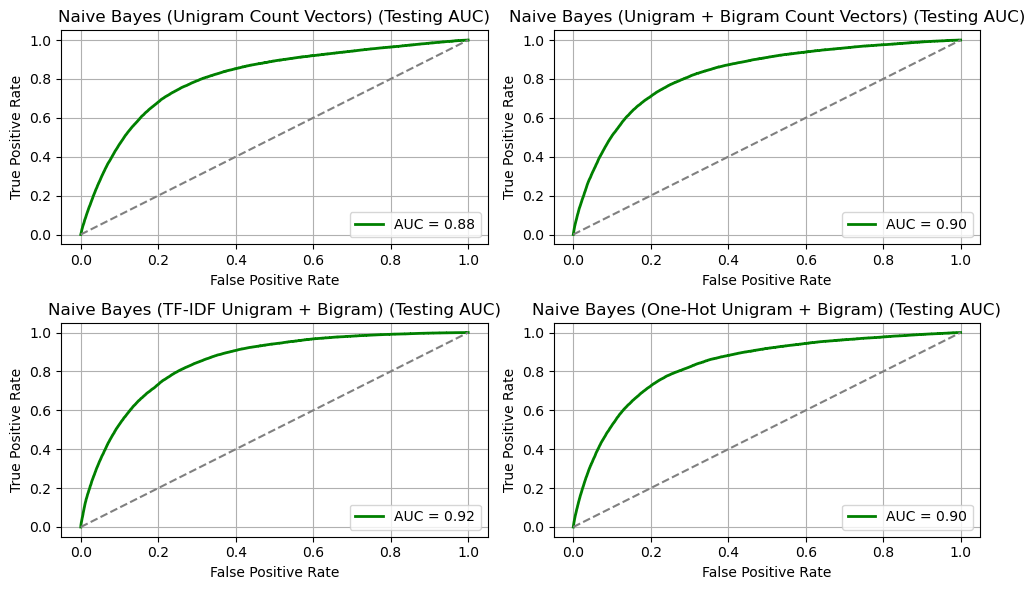

In [591]:
plot_testing_auc(testing_models)

### Confusion Matrices

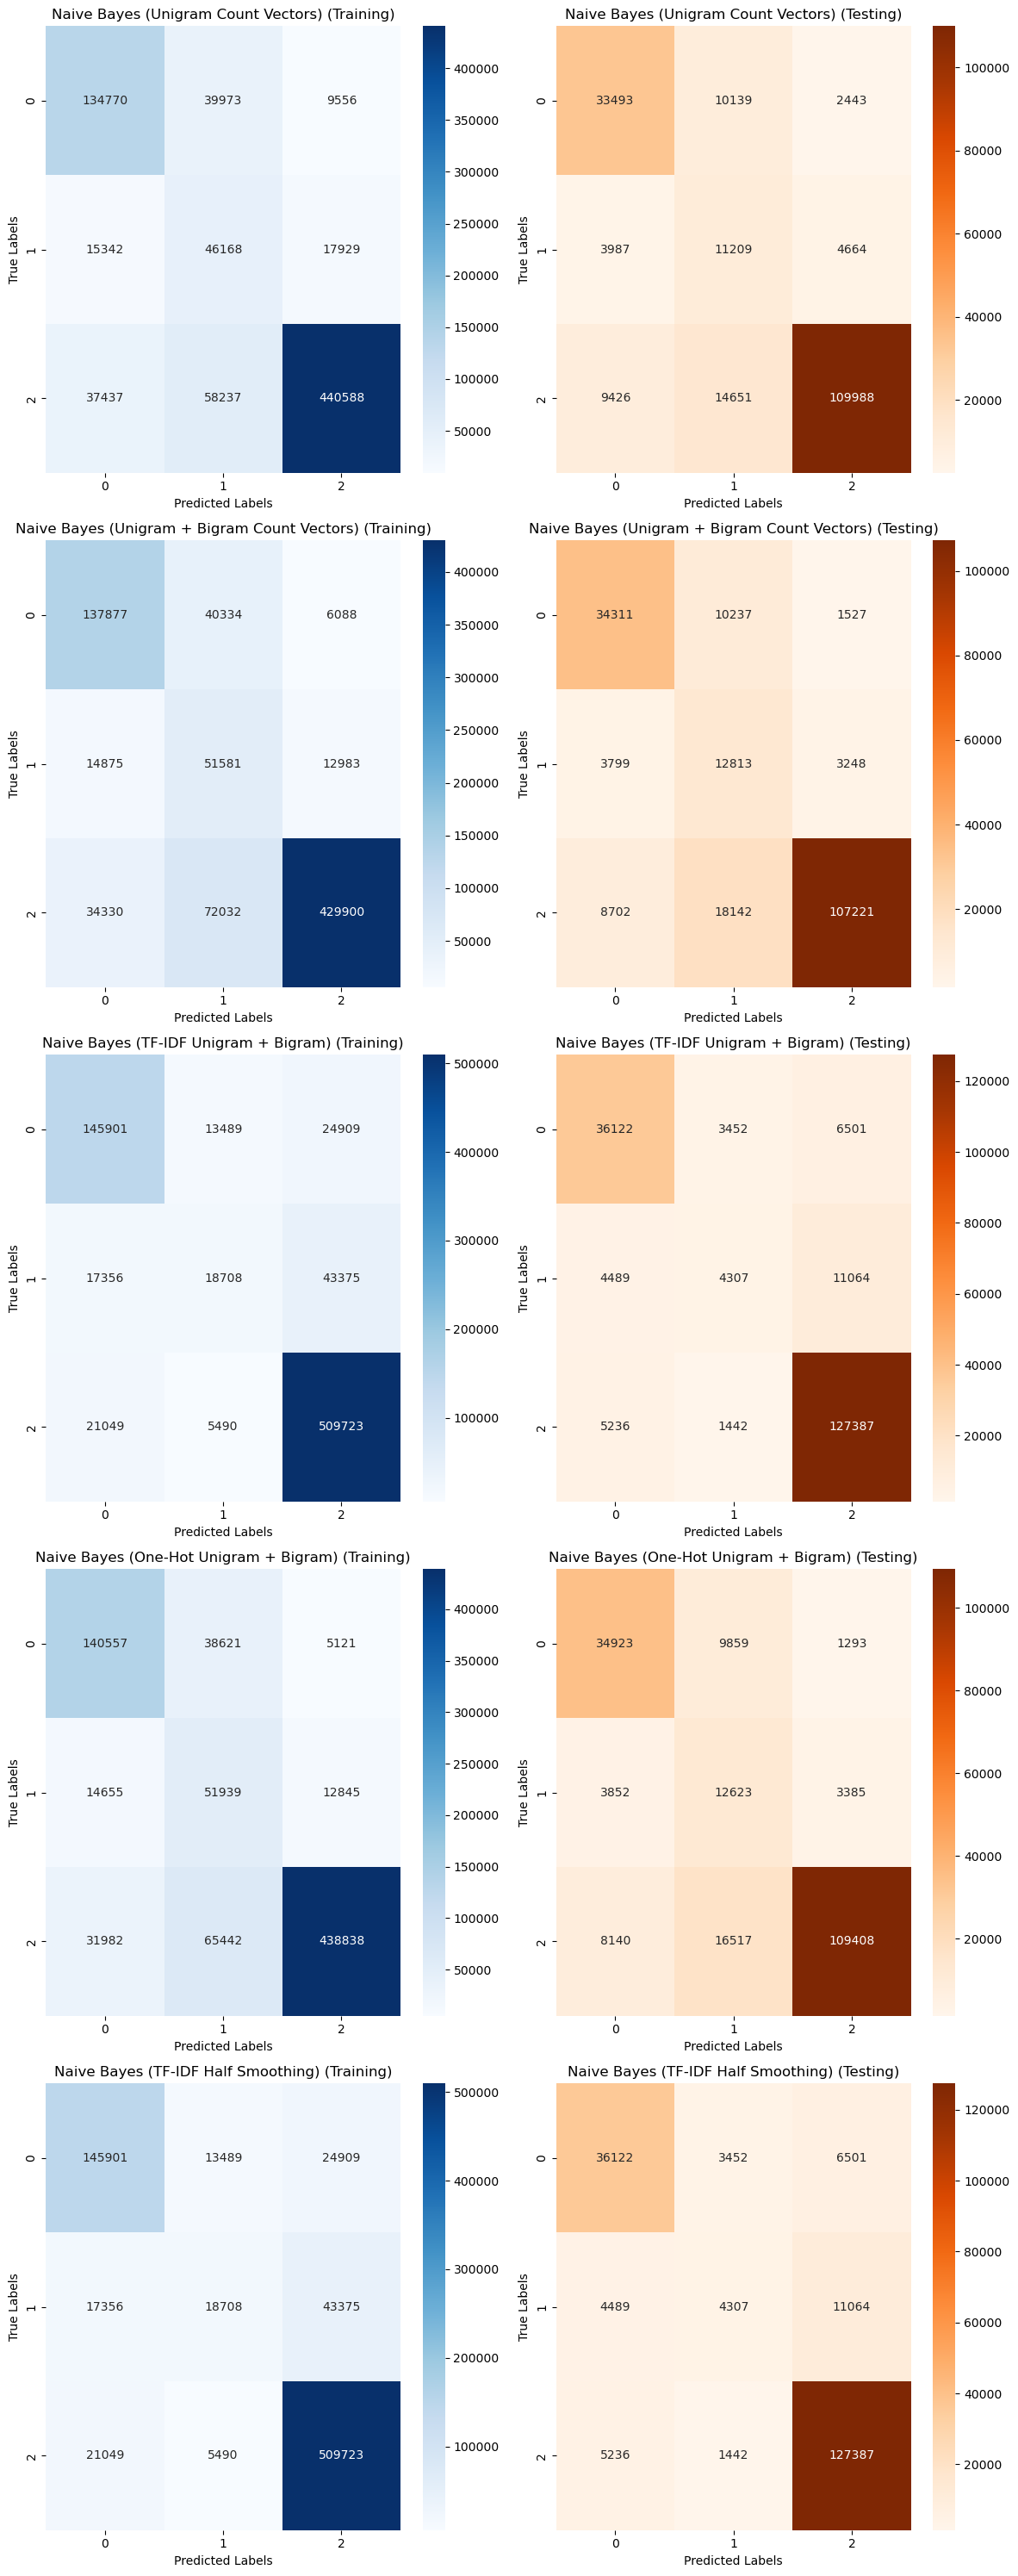

In [633]:
plot_confusion_matrices(confusion_matrix_models)

In [596]:
from joblib import dump

# Dump all models
dump(nb_model_count_unigram, "nb_model_unigram.joblib")  # Naive Bayes with Count Vectors (Unigram)
dump(nb_model_unigram_bigram, "nb_model_unigram_bigram.joblib")  # Naive Bayes with Count Vectors (Unigram + Bigram)
dump(nb_model_tfidf_unigram_bigram, "nb_model_tfidf_unigram_bigram.joblib")  # Naive Bayes with TF-IDF (Unigram + Bigram)
dump(nb_model_one_hot_unigram_bigram, "nb_model_one_hot_unigram_bigram.joblib")  # Naive Bayes with One-Hot (Unigram + Bigram)
print("Models Saved")

Models Saved


### Next Steps

1. More features can be included in TF - IDF vectors as it provides higher accuracy and AUC
2. All 4 models genralize well meaning more data can help improve accuracy and other metrics
3. Neutral Class can be balanced as F1-scores are lower for neutral class
4. Iterations can be performed on Smoothing parameter, as lowering parameter values did show slight change in accuracy however, not much. 